## AllLife Bank customer clustering

### Context:
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved.

Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the bank poorly.

Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster.

The Head of Marketing and the Head of Delivery both decide to reach out to the Data Science team for help.

### Objective:
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

### ALLLife bank data description:
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call center.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.color_palette()

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage,cophenet
from sklearn.metrics import silhouette_score

#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Warning
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.4f}".format

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Project-client-clustering/Credit Card Customer Data.xlsx')

In [ ]:
df.sample(10)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
559,560,81510,41000,7,5,2,3
493,494,20043,35000,6,2,1,4
103,104,73007,13000,1,0,3,7
134,135,31256,13000,4,1,5,7
422,423,49913,56000,6,3,1,0
523,524,63710,69000,6,3,0,2
22,23,30507,6000,4,1,4,6
212,213,94251,10000,3,1,3,4
530,531,30256,38000,4,3,0,0
539,540,51867,70000,4,4,1,0


In [ ]:
# fixing column names
df.columns = [c.replace(' ','_') for c in df.columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer_Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [ ]:
# Saving dataset
df_saved = df.copy()

In [ ]:
# No duplicates
df[df.duplicated() == True]

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [ ]:
# Same customer with two different data, I am assuming the Customer_Key is a type here. Since I am planning to delete this column I won't change much.
df[df['Customer_Key'] == 47437]

,Sl_No,Customer_Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0


In [ ]:
# Dropping 'ID' type of column
df = df.drop(['Customer_Key', 'Sl_No'], axis=1)

In [ ]:
# Missing values checking
pd.DataFrame(data={'% of Missing Values':round(df.isna().sum()/df.isna().count()*100,2)})

,% of Missing Values
Avg_Credit_Limit,0.0000
Total_Credit_Cards,0.0000
Total_visits_bank,0.0000
Total_visits_online,0.0000
Total_calls_made,0.0000


In [ ]:
# Numerical columns
num_cols = list(df._get_numeric_data().columns)
num_cols

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [ ]:
# Numerical discrete variables
num_cols_discrete = ['Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made'] 

In [ ]:
# Numerical continuous columns
num_cols_continuous = list(set(num_cols) - set(num_cols_discrete))
num_cols_continuous

['Avg_Credit_Limit']

In [ ]:
# Description
df.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.0000,660.0000,660.0000,660.0000,660.0000
mean,34574.2424,4.7061,2.4030,2.6061,3.5833
std,37625.4878,2.1678,1.6318,2.9357,2.8653
min,3000.0000,1.0000,0.0000,0.0000,0.0000
25%,10000.0000,3.0000,1.0000,1.0000,1.0000
50%,18000.0000,5.0000,2.0000,2.0000,3.0000
75%,48000.0000,6.0000,4.0000,4.0000,5.0000
max,200000.0000,10.0000,5.0000,15.0000,10.0000


In [ ]:
# Printing unique values
for i in num_cols_discrete:
  print(f'{i}: {df[i].nunique()}')

Total_Credit_Cards: 10
Total_visits_bank: 6
Total_visits_online: 16
Total_calls_made: 11


In [ ]:
for column in num_cols_discrete:
    print(df[column].value_counts())
    print('-'*50)

4     151
6     117
7     101
5      74
2      64
1      59
3      53
10     19
9      11
8      11
Name: Total_Credit_Cards, dtype: int64
--------------------------------------------------
2    158
1    112
3    100
0    100
5     98
4     92
Name: Total_visits_bank, dtype: int64
--------------------------------------------------
2     189
0     144
1     109
4      69
5      54
3      44
15     10
7       7
12      6
10      6
8       6
13      5
11      5
9       4
14      1
6       1
Name: Total_visits_online, dtype: int64
--------------------------------------------------
4     108
0      97
2      91
1      90
3      83
6      39
7      35
9      32
8      30
5      29
10     26
Name: Total_calls_made, dtype: int64
--------------------------------------------------


**Observations:**

Mean:

* `Avg_Credit_Limit:` 34574.24
* `Total_Credit_Cards:`4.70
* `Total_visits_bank:`2.40
* `Total_visits_online:`2.60
* `Total_calls_made:`3.58

**Checking each feature for 0**

In [ ]:
df[(df.Avg_Credit_Limit == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [ ]:
df[(df.Total_Credit_Cards == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made


In [ ]:
df[(df.Total_visits_bank == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
1,50000,3,0,10,9
4,100000,6,0,12,3
5,20000,3,0,1,8
6,100000,5,0,11,2
7,15000,3,0,1,1
...,...,...,...,...,...
645,171000,10,0,15,0
646,186000,7,0,8,1
647,183000,9,0,9,2
653,95000,10,0,15,1


**Comment** `Total_visits_bank` 100 rows with zeros.

In [ ]:
df[(df.Total_visits_online == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
228,10000,7,2,0,0
230,17000,4,5,0,2
234,16000,6,5,0,4
235,13000,7,4,0,0
237,8000,6,4,0,4
...,...,...,...,...,...
589,29000,4,5,0,2
600,68000,7,5,0,0
601,33000,5,4,0,2
602,37000,7,4,0,1


**Comment** `Total_visits_online` 144 rows with zeros.

In [ ]:
df[(df.Total_calls_made == 0)]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
228,10000,7,2,0,0
232,20000,5,4,1,0
233,13000,7,2,1,0
235,13000,7,4,0,0
...,...,...,...,...,...
645,171000,10,0,15,0
648,111000,8,1,7,0
652,156000,8,1,8,0
655,99000,10,1,10,0


**Comment** `Total_calls_made` 97 rows with zeros.

#### Exploratory Data Analysis

- Univariate analysis
- Bivariate analysis 
- Multivariate analysis

In [ ]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(10,7), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='lightblue') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='blue', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

##### Univariate Analysis (continuous numerical)

In [ ]:
# Mean, Median and Mode
for i in num_cols_continuous:
    mean=df[i].mean()
    median=df[i].median()
    mode=df[i].tolist()[0]
    print(f'Feature: {i}, Mean: {mean}, Median: {median}, Mode: {mode}')

Feature: Avg_Credit_Limit, Mean: 34574.242424242424, Median: 18000.0, Mode: 100000


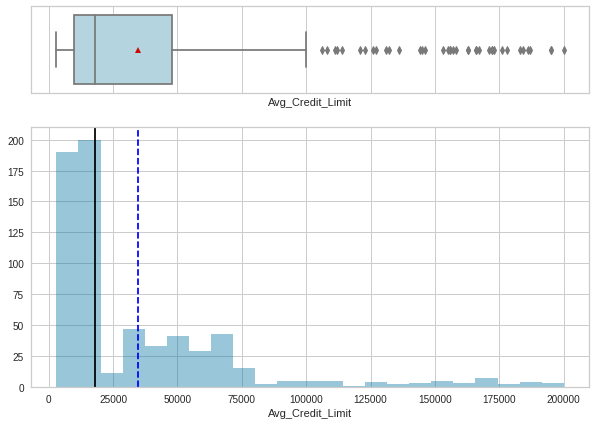

In [ ]:
# Avg_Credit_Limit
histogram_boxplot(df['Avg_Credit_Limit'])

**Comment:** 

- Skew: Right
- Normal distribution: No
- Outliers: Right

##### Univariate analysis (discrete numerical)

In [ ]:
# Mean, Median and Mode
for i in num_cols_discrete:
    mean=df[i].mean()
    median=df[i].median()
    mode=df[i].tolist()[0]
    print(f'Feature: {i}, Mean: {mean}, Median: {median}, Mode: {mode}')

Feature: Total_Credit_Cards, Mean: 4.706060606060606, Median: 5.0, Mode: 2
Feature: Total_visits_bank, Mean: 2.403030303030303, Median: 2.0, Mode: 1
Feature: Total_visits_online, Mean: 2.606060606060606, Median: 2.0, Mode: 1
Feature: Total_calls_made, Mean: 3.5833333333333335, Median: 3.0, Mode: 0


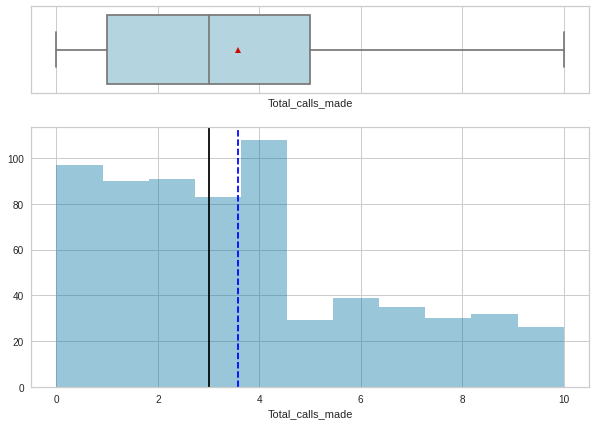

In [ ]:
# Total_calls_made
histogram_boxplot(df['Total_calls_made'])

**Comment:** 

- Skew: Right
- Normal distribution: No
- Outliers: No

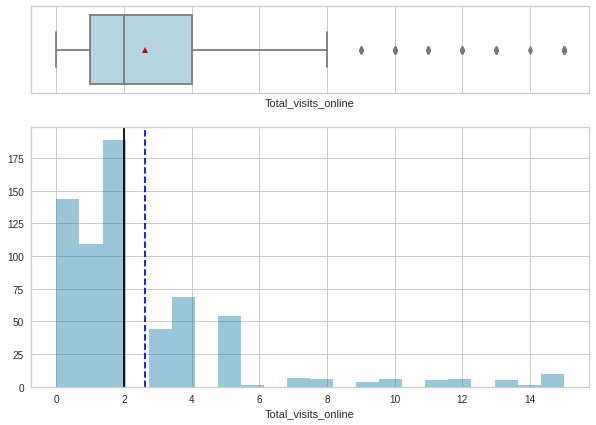

In [ ]:
# Total_visits_online
histogram_boxplot(df['Total_visits_online'])

**Comment:** 

- Skew: Right
- Normal distribution: No
- Outliers: Right

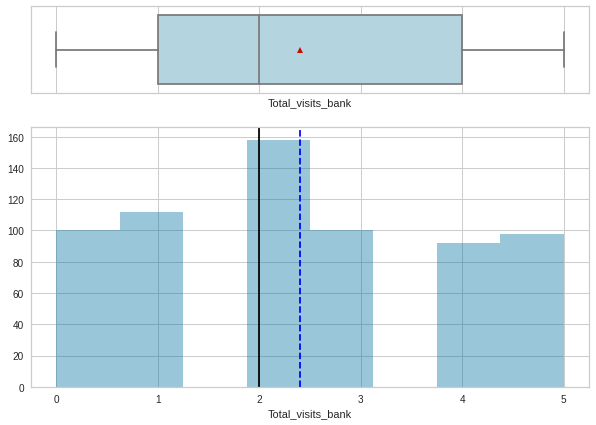

In [ ]:
# Total_visits_bank
histogram_boxplot(df['Total_visits_bank'])

**Comment:** 

- Skew: Right
- Normal distribution: No
- Outliers: No

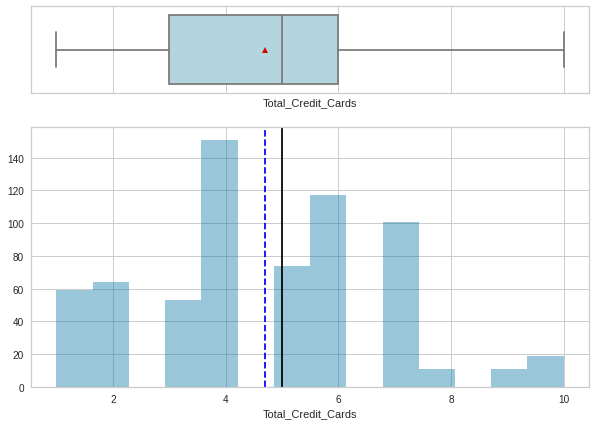

In [ ]:
# Total_Credit_Cards
histogram_boxplot(df['Total_Credit_Cards'])

**Comment:** 

- Skew: left
- Normal distribution: No
- Outliers: No

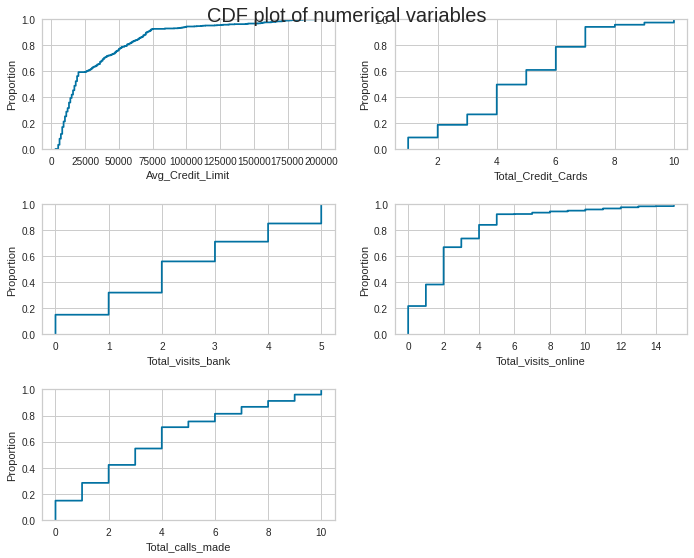

In [ ]:
# select numerical columns
all_col = df.select_dtypes(include=np.number).columns.tolist()

fig, axes = plt.subplots(3, 2,  figsize=(10, 8))
fig.suptitle('CDF plot of numerical variables', fontsize=20)
counter = 0
for ii in range(3):
    sns.ecdfplot(ax=axes[ii][0],x=df[all_col[counter]])
    counter = counter+1
    if counter != 5:
        sns.ecdfplot(ax=axes[ii][1],x=df[all_col[counter]])
        counter = counter+1
    else:
        pass
axes[2,1].set_axis_off();


fig.tight_layout(pad=2.0)

##### Bivariate Analysis

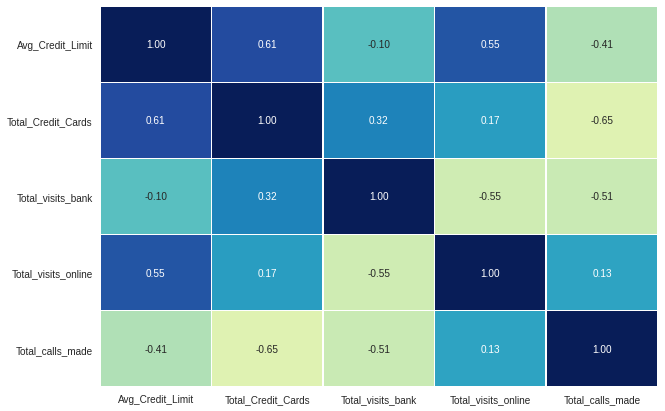

In [ ]:
plt.figure(figsize=(10,7))

sns.heatmap(df[all_col].corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu",
            fmt='0.2f')            

plt.show()

* `'Avg_Credit_Limit'` vs. `'Total_calls_made'` Negative correlated
* `'Avg_Credit_Limit':` vs. `'Total_visits_online'` Positive correlated
* `'Avg_Credit_Limit':` vs. `'Total_Credit_Cards'` Positive correlated
* `'Total_calls_made'` vs. `'Total_Credit_Cards'` Negative correlated
* `'Total_visits_bank'` vs. `'Total_Credit_Cards'` Positive correlated
* `'Total_visits_bank'` vs. `'Total_visits_online'` Negative correlated
* `'Total_visits_bank'` vs. `'Total_calls_made'` Negative correlated

* There is no correlations above +/- 0.75 threshold 

##### Any other exploratory deep dive

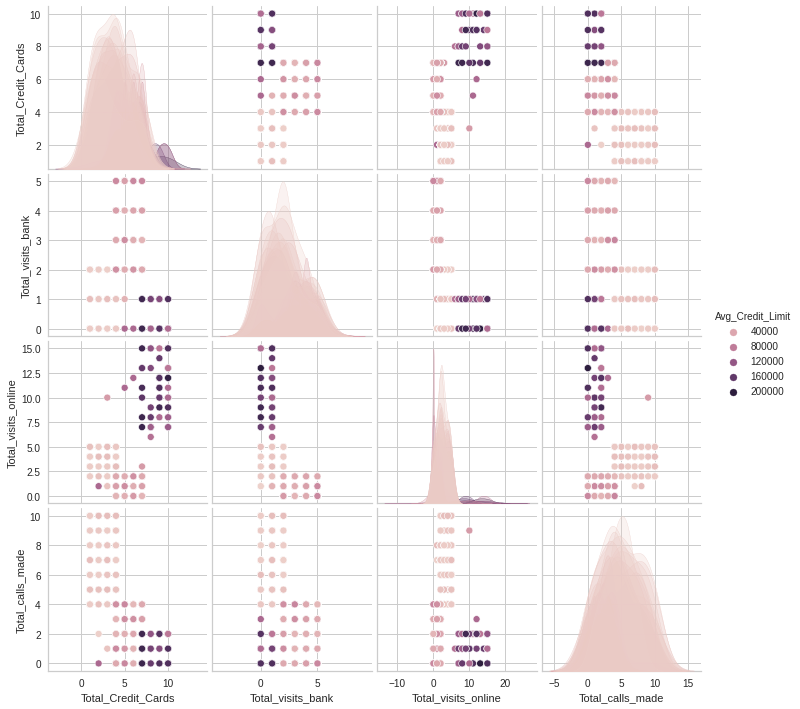

In [ ]:
sns.pairplot(df, hue='Avg_Credit_Limit');

#### Illustrate the insights based on EDA

Observations (Mean):

* `Avg_Credit_Limit:` 34574.24
* `Total_Credit_Cards:`4.70
* `Total_visits_bank:`2.40
* `Total_visits_online:`2.60
* `Total_calls_made:`3.58


Univariate Analysis (continuous numerical)

* Feature: Avg_Credit_Limit, Mean: 34574.242424242424, Median: 18000.0, Mode: 100000

Univariate analysis (discrete numerical)

* Feature: Total_Credit_Cards, Mean: 4.706060606060606, Median: 5.0, Mode: 2
* Feature: Total_visits_bank, Mean: 2.403030303030303, Median: 2.0, Mode: 1
* Feature: Total_visits_online, Mean: 2.606060606060606, Median: 2.0, Mode: 1
* Feature: Total_calls_made, Mean: 3.5833333333333335, Median: 3.0, Mode: 0

Bivariate analysis

* `'Avg_Credit_Limit'` vs. `'Total_calls_made'` Negative correlated
* `'Avg_Credit_Limit':` vs. `'Total_visits_online'` Positive correlated
* `'Avg_Credit_Limit':` vs. `'Total_Credit_Cards'` Positive correlated
* `'Total_calls_made'` vs. `'Total_Credit_Cards'` Negative correlated
* `'Total_visits_bank'` vs. `'Total_Credit_Cards'` Positive correlated
* `'Total_visits_bank'` vs. `'Total_visits_online'` Negative correlated
* `'Total_visits_bank'` vs. `'Total_calls_made'` Negative correlated

* There is no correlations above +/- 0.75 threshold 


#### Data pre-processing
- Prepare the data for analysis
- Feature Engineering
- Missing value Treatment
- Outlier Treatment
- Duplicate observations check and removal if found

##### Outliers Treatment

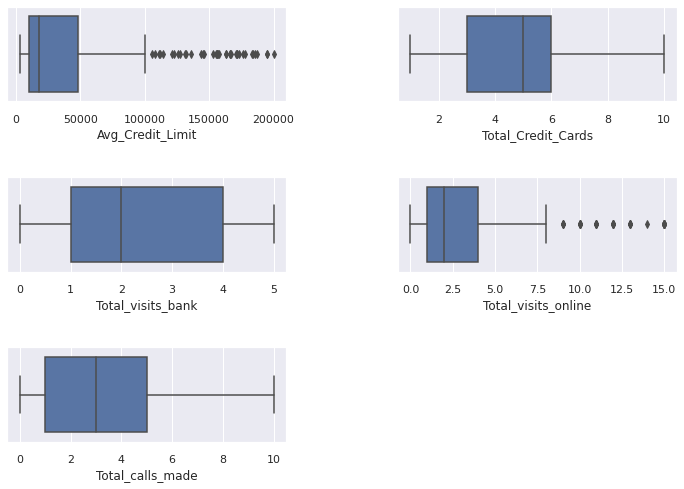

In [ ]:
# Visually checking distributions
sns.set(font_scale=1)
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(3,2, figsize=(12,8))
fig.subplots_adjust(hspace=0.8, wspace=0.4)
for axis, element in zip(axes.flat, numerical_col):
    sns.boxplot(df[element], ax=axis)
axes[2,1].set_axis_off();

In [ ]:
# Lets treat outliers by flooring and capping
def treat_outliers(df,col):
    '''
    treats outliers in a variable
    df: data frame
    col: name of the feature
    '''
    
    # Defining quantiles:
    # 25th quantile
    Q1=df[col].quantile(0.25)
    
    # 75th quantile
    Q3=df[col].quantile(0.75)
    
    # Inter quantile Q3 - Q1;
    IQR=Q3-Q1
    
    # Base quantile less 1.5*IQR
    Lower_Whisker = Q1 - 1.5*IQR
    if Lower_Whisker < 0:
        Lower_Whisker = 0
    
    
    # Top quantile plus 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    
 
    # assigning max and min value to the array, meaning that outliers will be subscribed by:
    # min (Lower_Whisker) 
    # max (Upper_Whisker)
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) 
    
    # returning clipped data
    return df

def treat_outliers_all(df, col_list):
    '''
    treat outlier in all numerical variables
    col_list: list of numerical variables
    df: data frame
    '''
    # Looping through the data and applying the function "treat_outliers"
    for c in col_list:
        df = treat_outliers(df,c)
        
    return df

In [ ]:
# Applying the outliers treatment
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
numerical_col

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [ ]:
# passing the columns and the dataframe in order to remove outliers
df_outliers_treated = treat_outliers_all(df,numerical_col)

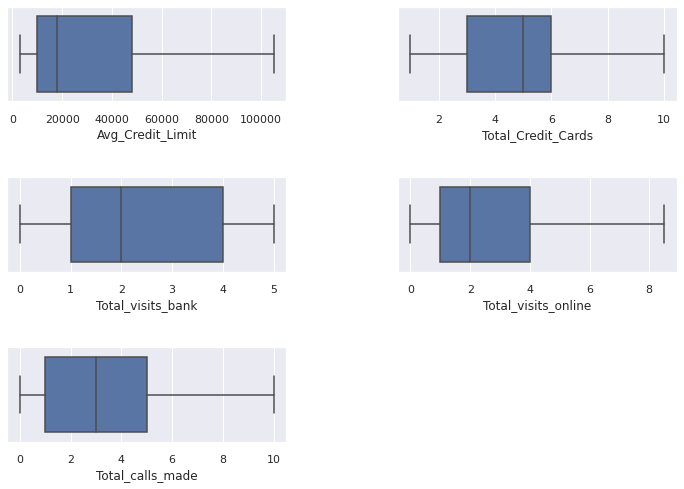

In [ ]:
# Visually checking distributions
sns.set(font_scale=1)
numerical_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(3,2, figsize=(12,8))
fig.subplots_adjust(hspace=0.8, wspace=0.4)
for axis, element in zip(axes.flat, numerical_col):
    sns.boxplot(df[element], ax=axis)
axes[2,1].set_axis_off();

In [ ]:
# Saving new dataframe
df_outliers = df_outliers_treated.copy()

##### Scaling the data

In [ ]:
# Scaling the dataset before clustering
scaler=StandardScaler()
subset=df_outliers.copy()
subset_scaled=scaler.fit_transform(subset)   

In [ ]:
# Creating a dataframe of the above results
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)

#### Applying K-means clustering algorithms


##### Apply K-means - Elbow curve


Number of Clusters: 1 	Average Distortion: 2.0731463576129583
Number of Clusters: 2 	Average Distortion: 1.498614150179638
Number of Clusters: 3 	Average Distortion: 1.1823298853410937
Number of Clusters: 4 	Average Distortion: 1.0711026440504197
Number of Clusters: 5 	Average Distortion: 1.0048733481248668
Number of Clusters: 6 	Average Distortion: 0.952286422455576
Number of Clusters: 7 	Average Distortion: 0.9149353103731805
Number of Clusters: 8 	Average Distortion: 0.8904518581086218


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

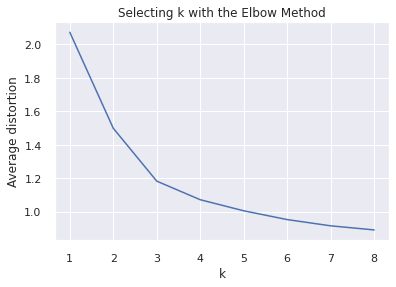

In [ ]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

**Appropriate k seems to be a 2 or 3.**

##### Silhouette Score


For n_clusters = 2, silhouette score is 0.4201583924929177)
For n_clusters = 3, silhouette score is 0.5169867470092899)
For n_clusters = 4, silhouette score is 0.38147048130671246)
For n_clusters = 5, silhouette score is 0.3535307587712862)
For n_clusters = 6, silhouette score is 0.27140961970799754)
For n_clusters = 7, silhouette score is 0.2677109078455558)
For n_clusters = 8, silhouette score is 0.2565496132058947)
For n_clusters = 9, silhouette score is 0.2419139716094377)


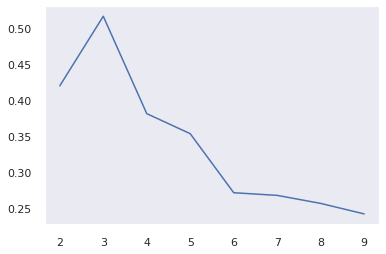

In [ ]:
sil_score = []
cluster_list = list(range(2,10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    #centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list,sil_score)
plt.grid()

**Silhouette score for 3 is the highest.**

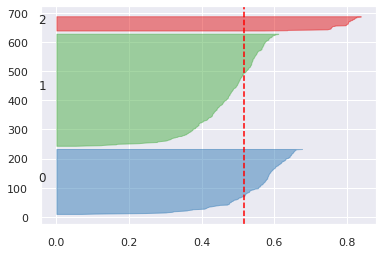

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(subset_scaled_df);    
# visualizer.show();

**Cluster 2 seems to be too thin in comparison to the others.**

**Cluster 1 seems to be too large in comparison to the others.**

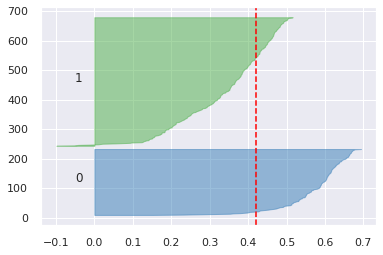

In [ ]:
#Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(2, random_state = 1))
visualizer.fit(subset_scaled_df);
# visualizer.show();

**Let us take 3 as appropriate no. of clusters as silhoutte score is high enough and there is knick at 3 in elbow curve.**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
df_outliers['K_means_segments'] = kmeans.labels_

##### Cluster Profiling

In [ ]:
cluster_profile = df_outliers.groupby('K_means_segments').mean()

In [ ]:
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
K_means_segments,,,,,
0,33782.3834,5.5155,3.4896,0.9819,2.0000
1,12174.1071,2.4107,0.9330,3.5469,6.8705
2,102660.0000,8.7400,0.6000,8.1800,1.0800


In [ ]:
cluster_profile['Freq'] = df_outliers.groupby('K_means_segments')['Avg_Credit_Limit'].count().values

In [ ]:
# lets display cluster profile
cluster_profile.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Freq
K_means_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.546875,6.870536,224
2,102660.000000,8.740000,0.600000,8.180000,1.080000,50


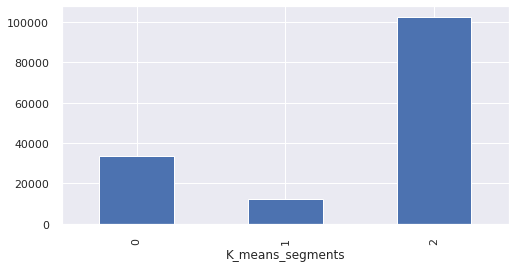

In [ ]:
# Checking the groups for Avg_Credit_Limit
cluster_profile['Avg_Credit_Limit'].groupby('K_means_segments').mean().plot.bar(figsize=(8,4));

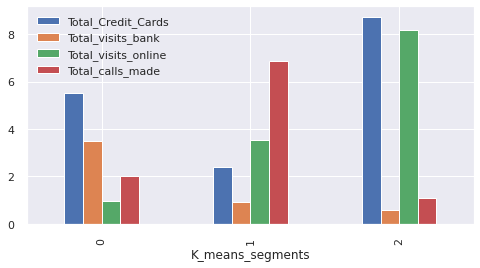

In [ ]:
# Checking the groups for the remainder features
cluster_profile[['Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']].groupby('K_means_segments').mean().plot.bar(figsize=(8,4));

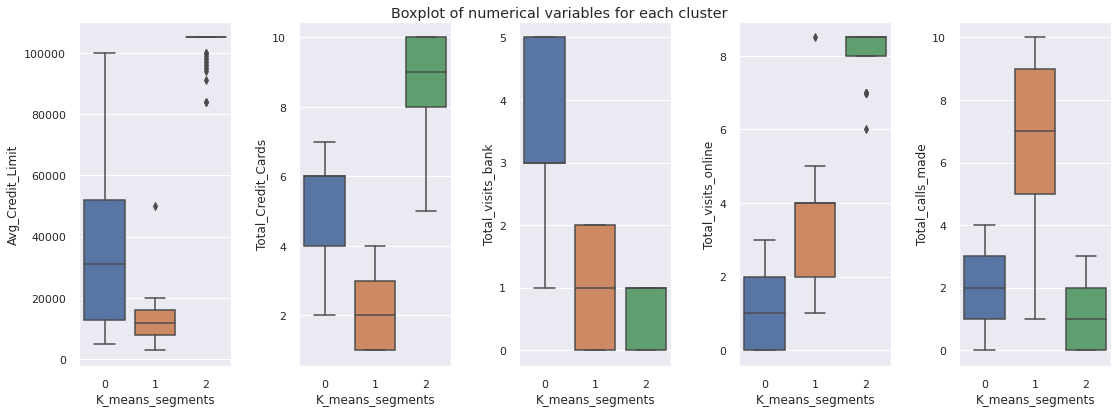

In [ ]:
list_columns =  cluster_profile.columns
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df_outliers[list_columns[counter]],x=df_outliers['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### **Insights K-means**
- Cluster 0 :
    - `Avg_Credit_Limit:` The mid end type of client.
    - `Total_Credit_Cards:` The mid end type of client.
    - `Total_visits_bank:` Visit the most the bank.
    - `Total_visits_online:` Doesn't access much the online bank.
    - `Total_calls_made:` Don't call as much as expected.
- Cluster 1 :
    - `Avg_Credit_Limit:` The lowest end type of client.
    - `Total_Credit_Cards:` The lowest end type of client.
    - `Total_visits_bank:` Doesn't visit much the bank.
    - `Total_visits_online:` Average end in terms of online banking usage.
    - `Total_calls_made:` The highest end type of client.
- Cluster 2 :
    - `Avg_Credit_Limit:` The highest end type of client.
    - `Total_Credit_Cards:` The highest end type of client.
    - `Total_visits_bank:` The lowest end type of client.
    - `Total_visits_online:` The highest end type of client.
    - `Total_calls_made:` The lowest end type of client.





#### Applying Hierarchical clustering


##### Apply Hierarchical clustering with different linkage methods and plot dendrograms for each linkage methods


In [ ]:
subset_scaled_df.sample(3)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
515,0.1872,-0.3259,0.9794,-0.1764,-0.5530
267,-0.5851,0.5973,0.9794,-1.0632,-0.9023
184,-0.6202,-0.3259,-1.4737,-0.1764,0.1455


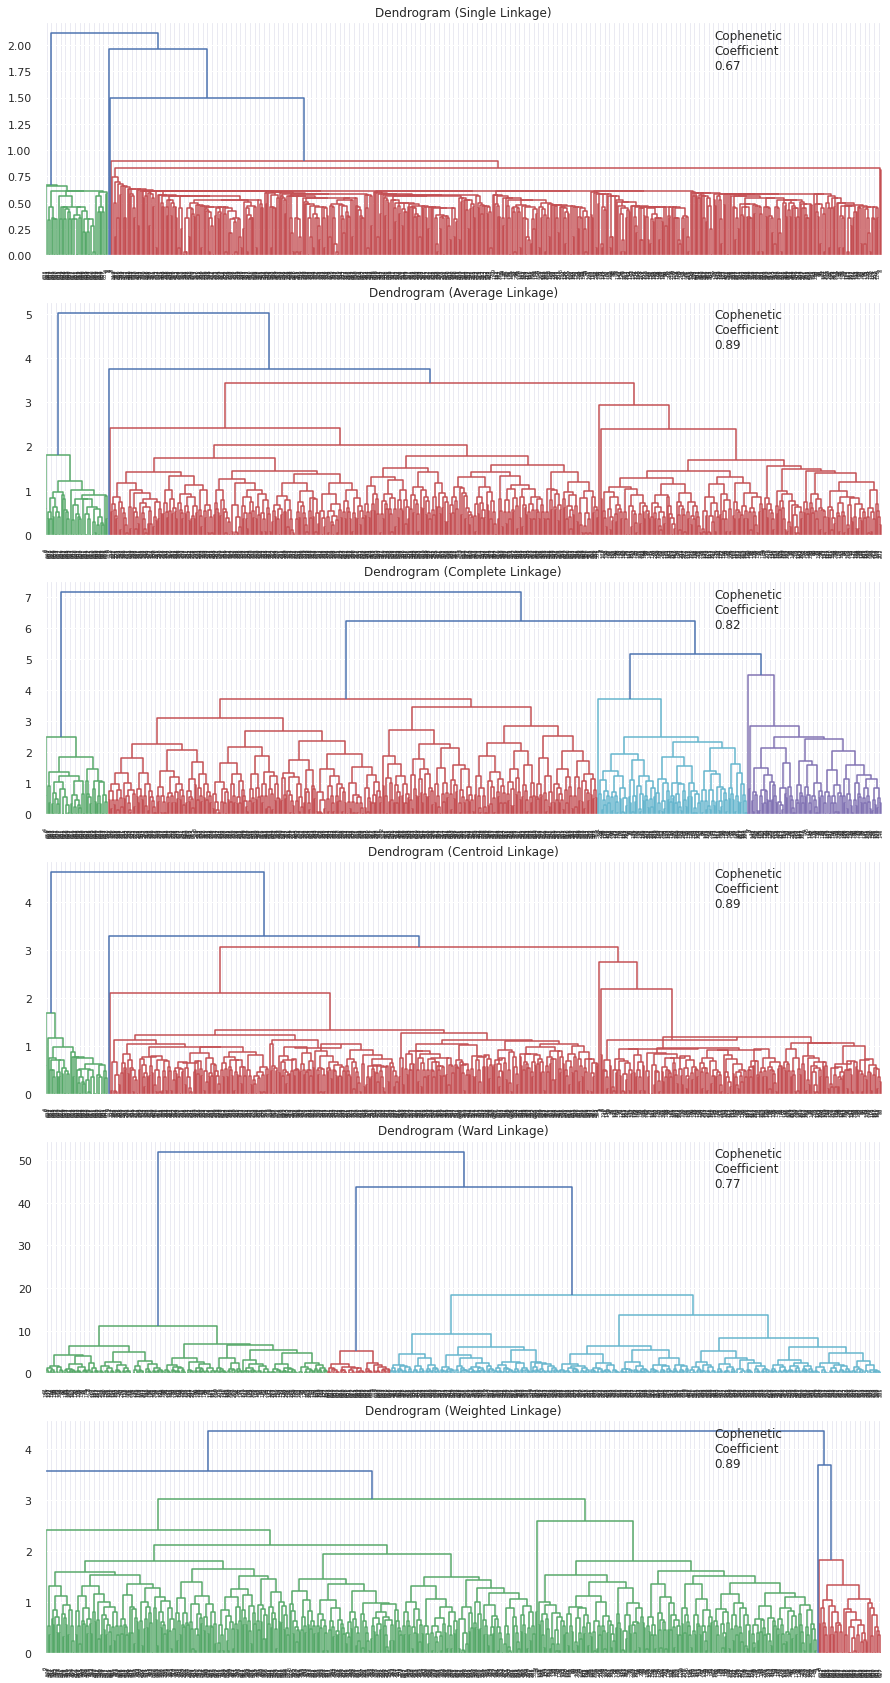

In [ ]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])

**Dendogran with `Weigthed, centroid and average Linkage` shows the distintic and separated cluster, which is represented by highest correlation score meaning that the clusters are separated from each other.**

In [ ]:
# cophenet index is a measure of the correlation between the distance of points in feature space and distance on dendrogram
# closer it is to 1, the better is the clustering
distance_metrics = [ 'euclidean','chebyshev','mahalanobis','cityblock']
linkage_methods = ['single', 'complete', 'average', 'weighted']
high_cophenet_corr = 0
high_dm_lm = [0,0]
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z , pdist(subset_scaled_df))
        print('Cophent correlation for distance metrics {} and linkage method {} is {}'.format(dm,lm,c))
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm
            

Cophent correlation for distance metrics euclidean and linkage method single is 0.6666982080229052
Cophent correlation for distance metrics euclidean and linkage method complete is 0.8207314650343172
Cophent correlation for distance metrics euclidean and linkage method average is 0.8926672966587857
Cophent correlation for distance metrics euclidean and linkage method weighted is 0.8872365340578663
Cophent correlation for distance metrics chebyshev and linkage method single is 0.6882876568342585
Cophent correlation for distance metrics chebyshev and linkage method complete is 0.7672199195985938
Cophent correlation for distance metrics chebyshev and linkage method average is 0.8907216945489853
Cophent correlation for distance metrics chebyshev and linkage method weighted is 0.782728724334691
Cophent correlation for distance metrics mahalanobis and linkage method single is 0.658393428048562
Cophent correlation for distance metrics mahalanobis and linkage method complete is 0.3884943792102

In [ ]:
print('Highest cophenet correlation is {}, which is obtinaed with {} distance metric and {} linkage method'.format(high_cophenet_corr ,high_dm_lm[0],high_dm_lm[1]))

Highest cophenet correlation is 0.8926672966587857, which is obtinaed with euclidean distance metric and average linkage method


In [ ]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.6667
1,average,0.8927
2,complete,0.8207
3,centroid,0.8881
4,ward,0.7702
5,weighted,0.8872


##### Creating 3 clusters

In [ ]:
from sklearn.cluster import AgglomerativeClustering 
#Trying with K value as 3
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage='average')
HCmodel.fit(subset_scaled_df)
subset_scaled_df['HC_Clusters'] = HCmodel.labels_

In [ ]:
df_outliers['HC_Clusters'] = HCmodel.labels_

In [ ]:
cluster_profile_HC = df_outliers.groupby('HC_Clusters').mean()

In [ ]:
cluster_profile_HC

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments
HC_Clusters,,,,,,
0,25725.7800,4.3793,2.5534,1.9253,3.7947,0.3678
1,102660.0000,8.7400,0.6000,8.1800,1.0800,2.0000
2,100000.0000,2.0000,1.0000,1.0000,0.0000,0.0000


In [ ]:
cluster_profile_HC['Freq'] = df_outliers.groupby('HC_Clusters')['Avg_Credit_Limit'].count().values

In [ ]:
# lets display cluster profile
cluster_profile_HC.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,Freq
HC_Clusters,,,,,,,
0,25725.779967,4.379310,2.553366,1.925287,3.794745,0.367816,609
1,102660.000000,8.740000,0.600000,8.180000,1.080000,2.000000,50
2,100000.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1


**It seems that for hierarchical approach 2 clusters is a better choice since the `Freq` of cluster 1 is defined by only 6 elements.**

In [ ]:
all_col = df_outliers.columns

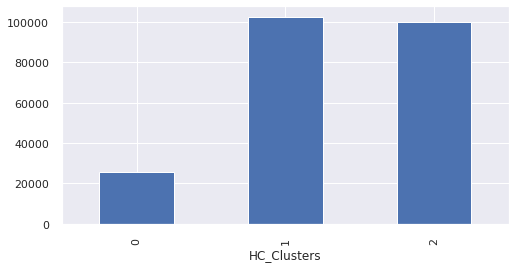

In [ ]:
# Checking the groups for Avg_Credit_Limit
cluster_profile_HC['Avg_Credit_Limit'].groupby('HC_Clusters').mean().plot.bar(figsize=(8,4));

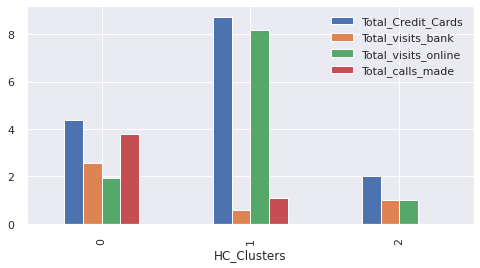

In [ ]:
# Checking the groups for the remainder features
cluster_profile_HC[['Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']].groupby('HC_Clusters').mean().plot.bar(figsize=(8,4));

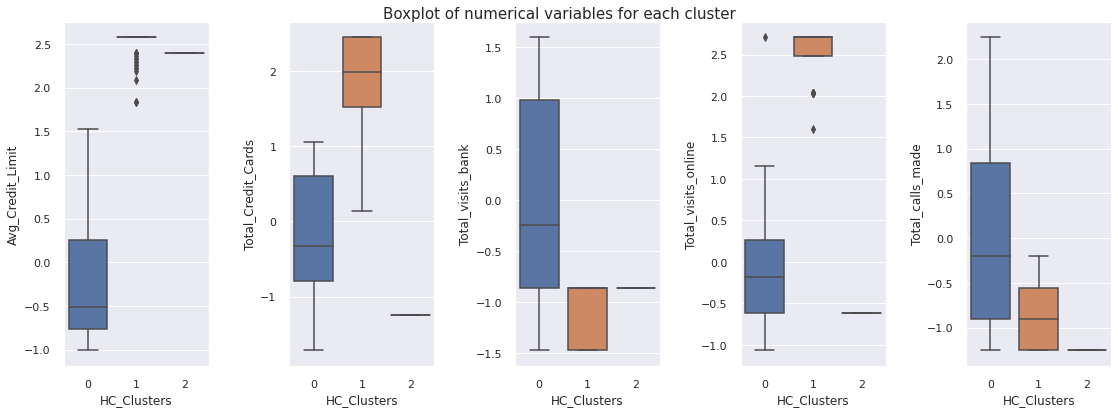

In [ ]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=15)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### **Insights hierarchical clustering**
- Cluster 0 :
    - `Avg_Credit_Limit:` The lowest end type of client.
    - `Total_Credit_Cards:` The lowest end type of client.
    - `Total_visits_bank:` The lowest end type of client.
    - `Total_visits_online:` The mid end type of client.
    - `Total_calls_made:` The mid end type of client.
- Cluster 1 :
    - `Avg_Credit_Limit:` The highest end type of client.
    - `Total_Credit_Cards:` The mid end type of client.
    - `Total_visits_bank:` The lowest end type of client.
    - `Total_visits_online:` The highest end type of client.
    - `Total_calls_made:` The highest end type of client.
- Cluster 2 :
    - `Avg_Credit_Limit:` The mid end type of client.
    - `Total_Credit_Cards:` The highest end type of client.
    - `Total_visits_bank:` The mid end type of client.
    - `Total_visits_online:` The lowest end type of client.
    - `Total_calls_made:` The lowest end type of client.



#### Compare cluster K-means clusters and Hierarchical clusters



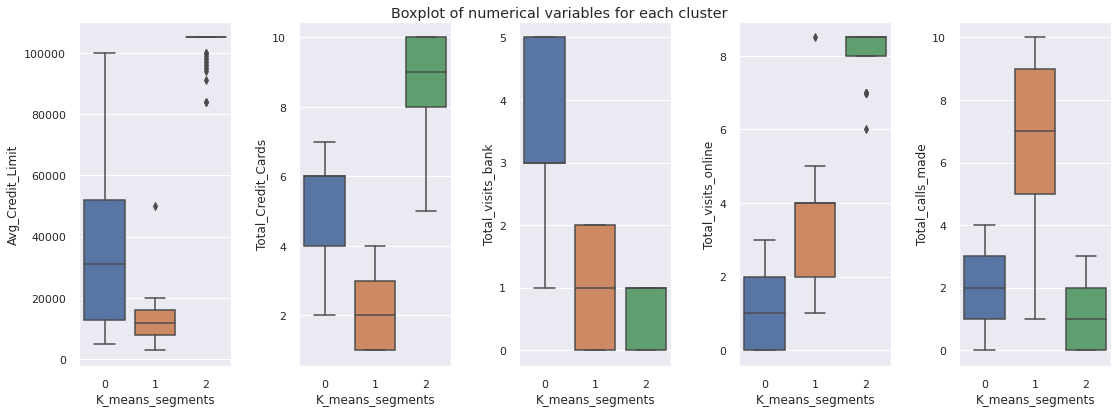

In [ ]:
list_columns =  cluster_profile.columns
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=df_outliers[list_columns[counter]],x=df_outliers['K_means_segments'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### **Conclusions K-means**

- `Cluster 0` : Seems to be type of clients with the lowest credit limit, more willing to visit the bank.
- `Cluster 1` : Mid range type of client a mix between cluster 2 and cluster 0.
- `Cluster 2` : Seems to be the type of client with the highest credit limit, more willing to use online banking system.

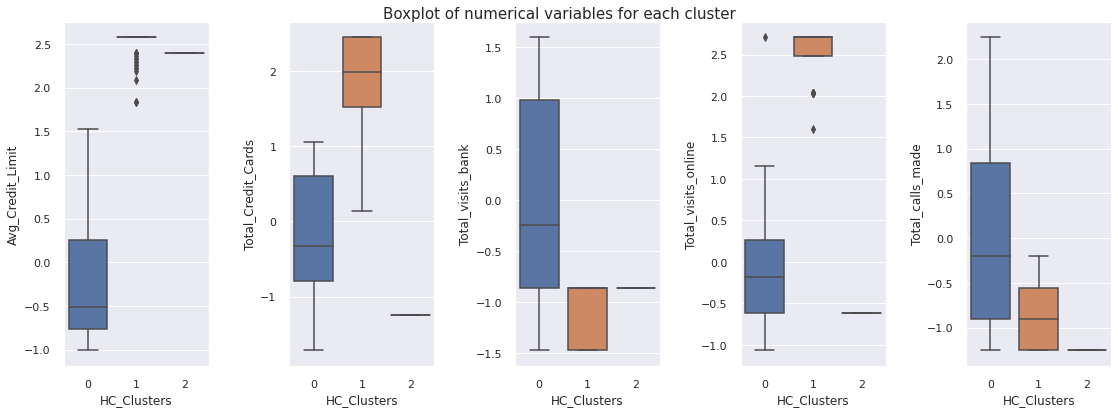

In [ ]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=15)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

#### **Conclusions Hierarchical clusters**
- `Cluster 0` : Seems to be type of clients with the lowest credit limit.
- `Cluster 1` : Seems to be type of clients with the highest credit limit. A client that demands online and mobile contact.
- `Cluster 2` : Seems to be the type of client with the mid credit limit range, a type of client that do not visit the bank neither use the online banking.

### Actionable Recommendations

3 different clusters with two different methods `kmeans` and `hierarchical clustering`.

1. How are these segments different from each other?

The clusters are divided based on their credit limit and their needs to contact the bank. The client have the option to visit the bank, to use the call center or to use the online banking.

**Insights K-means**
- Cluster 0 :
    - `Avg_Credit_Limit:` The mid end type of client.
    - `Total_Credit_Cards:` The mid end type of client.
    - `Total_visits_bank:` Visit the most the bank.
    - `Total_visits_online:` Doesn't access much the online bank.
    - `Total_calls_made:` Don't call as much as expected.
- Cluster 1 :
    - `Avg_Credit_Limit:` The lowest end type of client.
    - `Total_Credit_Cards:` The lowest end type of client.
    - `Total_visits_bank:` Doesn't visit much the bank.
    - `Total_visits_online:` Average end in terms of online banking usage.
    - `Total_calls_made:` The highest end type of client.
- Cluster 2 :
    - `Avg_Credit_Limit:` The highest end type of client.
    - `Total_Credit_Cards:` The highest end type of client.
    - `Total_visits_bank:` The lowest end type of client.
    - `Total_visits_online:` The highest end type of client.
    - `Total_calls_made:` The lowest end type of client.

**Insights hierarchical clustering**
- Cluster 0 :
    - `Avg_Credit_Limit:` The lowest end type of client.
    - `Total_Credit_Cards:` The lowest end type of client.
    - `Total_visits_bank:` The lowest end type of client.
    - `Total_visits_online:` The mid end type of client.
    - `Total_calls_made:` The mid end type of client.
- Cluster 1 :
    - `Avg_Credit_Limit:` The highest end type of client.
    - `Total_Credit_Cards:` The mid end type of client.
    - `Total_visits_bank:` The lowest end type of client.
    - `Total_visits_online:` The highest end type of client.
    - `Total_calls_made:` The highest end type of client.
- Cluster 2 :
    - `Avg_Credit_Limit:` The mid end type of client.
    - `Total_Credit_Cards:` The highest end type of client.
    - `Total_visits_bank:` The mid end type of client.
    - `Total_visits_online:` The lowest end type of client.
    - `Total_calls_made:` The lowest end type of client.

2. What are your recommendations to the bank on how to better market to and service these customers?

The bank received a lot of complains about their service to clients. However, not every single type of client require "attention" from the bank. 
The clusters helped us identify who were clients with the most credit limit, that hold the most credit cards and needed more attention from the bank which would be a group important to explore more their "share of wallet".


**Conclusions K-means**

    - `Cluster 0` : Seems to be type of clients with the lowest credit limit, more willing to visit the bank.
    - `Cluster 1` : Mid range type of client a mix between cluster 2 and cluster 0.
    - `Cluster 2` : Seems to be the type of client with the highest credit limit, more willing to use online banking system.

**Conclusions Hierarchical clusters**

    - `Cluster 0` : Seems to be type of clients with the lowest credit limit.
    - `Cluster 1` : Seems to be type of clients with the highest credit limit. A client that demands online and mobile contact.
    - `Cluster 2` : Seems to be the type of client with the mid credit limit range, a type of client that do not visit the bank neither use the online banking.

**Recommendations**

***Accessing customers with an upper credit limit seems to be the best strategy based on the analysis of the clusters.***

- `Kmeans -> Cluster 2` : Explore online marketing campaigns to this type of client. High financial potential in comparison with others clusters and desirous to access the bank online.

- `Hierarchical -> Cluster 1` : Explore online marketing campaigns to this type of client, and also develop a better approach in the call center. This type of client is willing to access the bank online however needs a better call center service.




## Using PCA to reduce the number of variables

**Let us use the PCA to reduce the dimensions so that it explains 80% variance**

In [ ]:
subset_scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_Clusters
0,2.3989,-1.2492,-0.8605,-0.6198,-1.2515,2
1,0.6436,-0.7876,-1.4737,2.7058,1.8919,0
2,0.6436,1.0590,-0.8605,0.2671,0.1455,0
3,-0.0585,0.1357,-0.8605,-0.6198,0.1455,0
4,2.3989,0.5973,-1.4737,2.7058,-0.2037,1
...,...,...,...,...,...,...
655,2.3638,2.4439,-0.8605,2.7058,-1.2515,1
656,1.8372,2.4439,-0.8605,2.7058,-0.5530,1
657,2.5745,1.5206,-0.8605,2.7058,-0.9023,1
658,2.5745,2.4439,-0.8605,2.7058,-1.2515,1


In [ ]:
subset_scaled_df2 = subset_scaled_df.drop('HC_Clusters',axis=1).copy()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(subset_scaled_df2)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
# Show variance explained by individual components
pca.explained_variance_ratio_

array([0.47196473, 0.34519351, 0.06514194, 0.06213265, 0.05556717])

Text(0, 0.5, 'Cumulative Explained Variance')

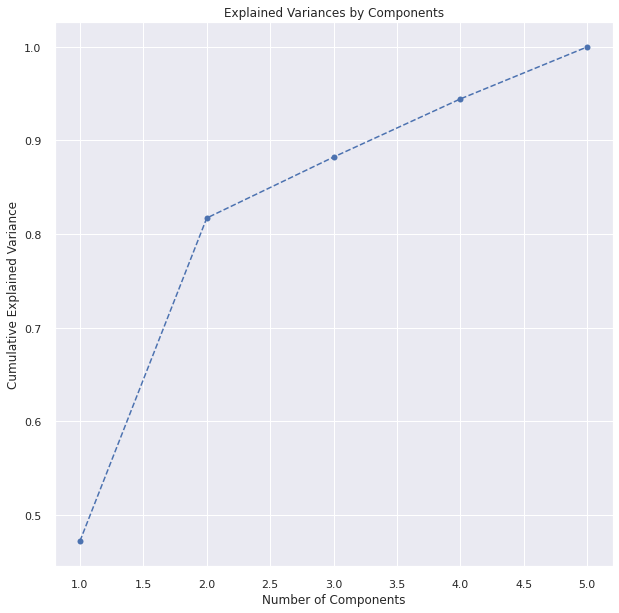

In [ ]:
# visulaize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

**for 90% variance , the number of components should be close to 3.5**

In [ ]:
pca = PCA(.9,svd_solver ='full') # svd_solver -full helps to converge faster in case of very large data set
pca.fit(subset_scaled_df2)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_

array([2.36340457, 1.72858663, 0.32620393, 0.31113468])

Text(0, 0.5, 'Cumulative Explained Variance')

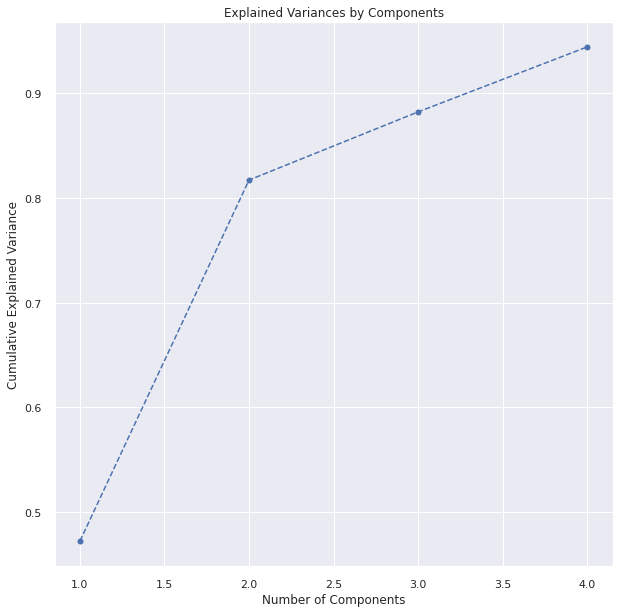

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

In [ ]:
subset_pca = pca.transform(subset_scaled_df2)
subset_pca = pd.DataFrame(subset_pca)

### Perform Clustering

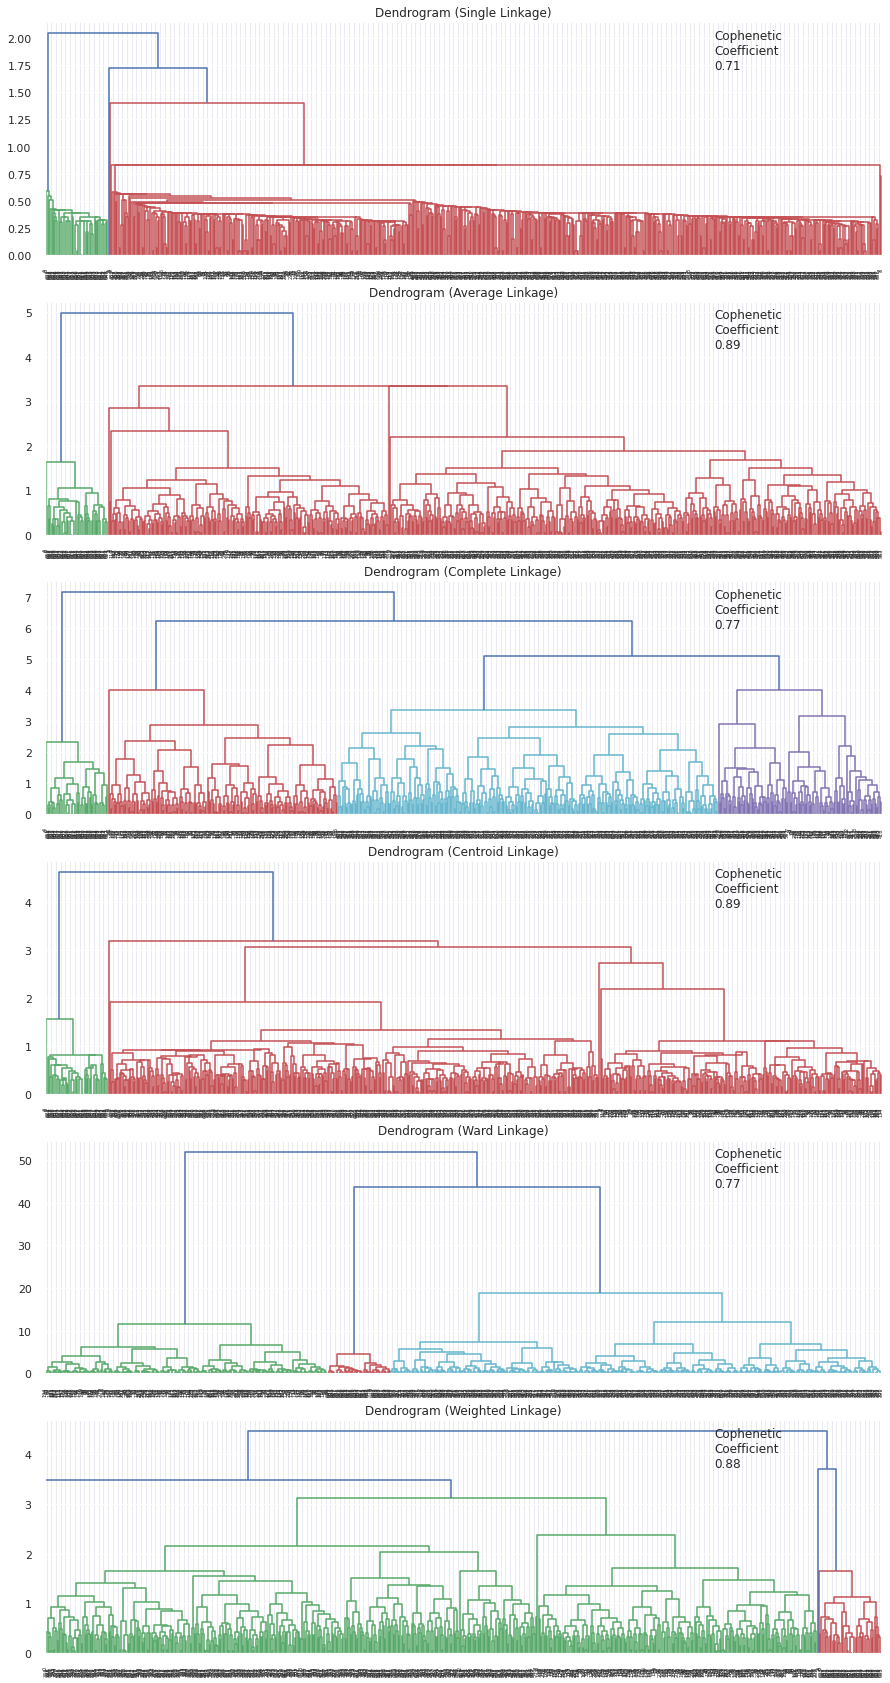

In [ ]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
# compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_pca, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df2))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
#     compare.append([method, coph_corr])

**It can be seen that ward linkage method show 4 as apt number of clusters**

In [ ]:
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hc_labels = hc.fit_predict(subset_pca)

In [ ]:
df_pca = df_outliers.copy()

In [ ]:
dff = df_pca.drop(['K_means_segments','HC_Clusters'] ,axis=1)

In [ ]:
dff['PCA_HC_clusters'] = hc_labels

In [ ]:
cluster_profile_PCA = dff.groupby('PCA_HC_clusters').mean()
cluster_profile_PCA['Freq'] = dff.groupby('PCA_HC_clusters')['Avg_Credit_Limit'].count().values

In [ ]:
# lets display cluster profile
cluster_profile_PCA.style.highlight_max(color = 'lightgreen', axis = 0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Freq
PCA_HC_clusters,,,,,,
0,19393.305439,5.589958,3.757322,0.995816,1.937238,239
1,12197.309417,2.403587,0.928251,3.553812,6.883408,223
2,102660.000000,8.740000,0.600000,8.180000,1.080000,50
3,56837.837838,5.385135,3.047297,0.966216,2.114865,148


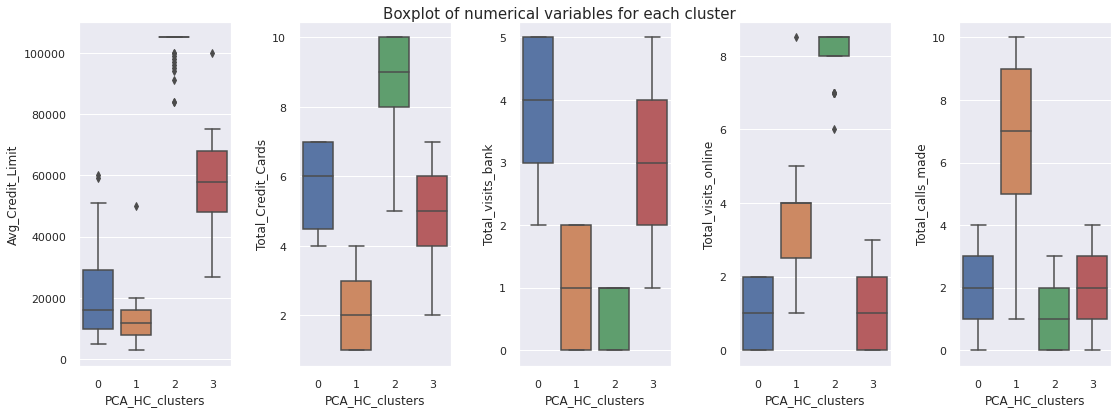

In [ ]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=15)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=dff[all_col[counter]],x=dff['PCA_HC_clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Insights**
- **Cluster 0**
   - Second lowest `Avg_Credit_Limit` with a higher variance.
   - Second highest number in `Total_Credit_Cards`.
   - `Total_visits_bank` biggest one.
   - `Total_visits_online` smallest one.
   - `Total_calls_made` avg of 2.
   - Clients visit in person.

- **Cluster 1**
   - The lowest `Avg_Credit_Limit` with a smaller variance.
   - The lowest number in `Total_Credit_Cards`.
   - `Total_visits_bank` second smallest.
   - `Total_visits_online` second biggest.
   - `Total_calls_made` The highest number of clients whom make phone calls.
   - Clients would rather call.
 
- **Cluster 2**
   - The highest `Avg_Credit_Limit` with a smallest variance.
   - The highest number in `Total_Credit_Cards`.
   - `Total_visits_bank` the smallest.
   - `Total_visits_online` the biggest.
   - `Total_calls_made` The smallest.
   - Clients would visit online.

- **Cluster 3**
   - The second highest `Avg_Credit_Limit` with a bigger variance.
   - The second biggest number in `Total_Credit_Cards`.
   - `Total_visits_bank` second smallest.
   - `Total_visits_online` the smallest.
   - `Total_calls_made` The second smallest.
   - Clients visit in person.
   

### Business Recommendations

**Cluster 0**

This type of customer has a good `Avg_Credit_Limit` and likes to visit the bank in person.
It is important to identify visiting patterns and improve your experience.

**Cluster 1**

This type of customer has a bad `Avg_Credit_Limit` and likes to call the bank. It is important to identify whether they are the type of customer the bank wants to invest in. Mainly because developing a better call center experience can be expensive and customers in this cluster enjoy the phone call experience.

**Cluster 2**

This type of customer has a good `Avg_Credit_Limit` and likes to visit the online bank. It is important to identify patterns of online visits and improve your experience by tracking your internet flow showing new products and services.


**Cluster 3**

This type of customer has a good `Avg_Credit_Limit` and likes to visit the bank in person. It is important to identify visiting patterns and improve their experience.
